# Below is with Generic Likelihood Model Class

In [1]:
import os, csv, random, time
from __future__ import division
from matplotlib import  pyplot as plt
import numpy as np
from scipy.stats import bernoulli,poisson,norm,expon
import scipy.io as sio
from scipy import stats
from collections import deque
from scipy import optimize
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

* The function $regularized\_vector$ is what Nihar proposed. 

Suppose $w^*$ is the true value and $\hat{w}$ is the inferred value from our optimization, we want to minimize $||w^* - a \cdot \hat{w} - b||_2^2 $ by finding optimial value of a and b, which will be done through $matching\_func$. And then we introduce a new value $v= a\cdot \hat{w} + b$ as the new weight for the videos. 

All the error metric evaluation would be made between $v$ and $w^*$, and here we are using $L_2$ norm, which is assessed through $performance_nihar$

* The function $performance\_isabelle$ is what Isabelle proposed.

Assume 3 scores $T_1, T_2, T_3$, that are adjacent when we rank all true scores, and the results scores of the corresponding videos $R_1, R_2, R_3$. We can compute $||\frac{T_2-T_1}{T_3-T_1+\epsilon}  - \frac{R_2-R_1}{R_3-R_1+\epsilon} ||$ and average over all adjacent triplets.

* Error using generative function is done through using a normal distribution that has a standard deviation of 3.33 and mean 0. The input is the difference of between the true score of the weights, and the corresponding function value from normal distribution is the probability of pairs being flipped. For instance, if the two values are very close to each other, then the chance of being flipped is the highest, at around 12%; if the values are very different, say 5 and -5, then the difference would be close to 10, which is at mean +/- 3 stds, which would correspond to a ~0% chance of being flipped.

In [13]:
class Pairwise(GenericLikelihoodModel):
    
    def __init__(self, endog, video_num, video_score, exog=None, **kwds):
        super(Pairwise, self).__init__(endog, exog, **kwds)
        self.rank =  deque([[1],[1]])
        self.w_hat = []
        self.video_num = video_num
        self.pairs_truth = self.endog
        self.total_pairs = len(self.endog)
        self.v = []
        self.w_star = np.array(video_score)
        
     
    def test_data_generation_sparsity(self, showResult=False, Nihar=False, Isabelle=False):
        
        """
        Shows how the error evolves with sparser data
        """
        
        all_data = self.endog
        
        num_test_pairs = (np.array((1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1))* self.total_pairs).astype(int)
        
        output_error_nihar = []
        output_error_isabelle = []

        for test_pair_num in num_test_pairs:
            print 'Current evaluating with %d test pairs' % test_pair_num
            test_pairs = [self.pairs_truth[i] for i in random.sample(range(self.total_pairs), test_pair_num)]
            self.endog = np.array(test_pairs)
            
            w_init = np.random.uniform(-5,5,video_num)
            self.fit(w_init)
            
            if showResult:
                res = self.rank[0]
                compare_rank(self.w_star, res, False, True)
                plt.legend([str(i) for i in num_test_pairs])  
            if Nihar:
                output_error_nihar.append(self.performance_nihar())
            if Isabelle:
                output_error_isabelle.append(self.performance_isabelle())
                
        self.endog = all_data
        return output_error_nihar, output_error_isabelle
        
        
    def test_data_generation_noise(self, showResult=False, Nihar=False, Isabelle=False):
        """
        Generate a decision of whether to flip, using a percentage and then select randomly to flip
        """
        all_data = self.endog

        num_test_pairs = self.total_pairs
        flip_threshold = np.array((0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5))
        
        output_error_nihar = []
        output_error_isabelle = []

        for to_flip in flip_threshold:
            print 'Current evaluating with %f to flip' % to_flip

            test_pairs_with_error = self.pairs_truth

            num_to_flip = int(num_test_pairs*to_flip)

            for i in random.sample(range(num_test_pairs), num_to_flip):
                test_pairs_with_error[i] = (self.pairs_truth[i][1],self.pairs_truth[i][0])

            self.endog = test_pairs_with_error
            
            w_init = np.random.uniform(-5,5,video_num)
            self.fit(w_init)

            if showResult:
                res = self.rank[0]
                compare_rank(self.w_star, res, False, True)
                plt.legend([str(i) for i in num_test_pairs])  
            if Nihar:
                output_error_nihar.append(self.performance_nihar())
            if Isabelle:
                output_error_isabelle.append(self.performance_isabelle())
                
        self.endog = all_data
        return output_error_nihar, output_error_isabelle
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def noise_generation(self, pair):
        """
        Generate a decision of whether to flip, using proability from normal distribution and then 
        Bernoulli to decide whether to flip
        """

#         difference = self.rank[0][pair[0]] - self.rank[0][pair[1]]
        difference = self.params[pair[0]] - self.params[pair[1]]
        p = self.sigmoid(difference)*(1-self.sigmoid(difference))
#         p = norm(0, 3.33).pdf(difference)
        decision = bernoulli.rvs(p,size=1)
        
        return decision
        
    
    
    def test_data_generation_noise_generative_model(self, showResult=False, Nihar=False, Isabelle=False):
        """
        Function that calculate error using normal distribution to determine the probility of whether to
        flip the pair. Highest chance, at scores equal is around 0.12
        """
        all_data = self.endog

        test_pairs = self.pairs_truth
        
        for i in range(self.total_pairs):
            if self.noise_generation(test_pairs[i]):
                test_pairs[i][0] = test_pairs[i][1]
                test_pairs[i][1] = self.pairs_truth[i][0]
                
        self.endog = test_pairs
        w_init = np.random.uniform(-5,5,video_num)
        self.fit(w_init)

        if showResult:
#             res = self.rank[0]
            compare_rank(self.w_star, res, False, True)
            plt.legend([str(i) for i in num_test_pairs])  
        if Nihar:
            print self.performance_nihar()
        if Isabelle:
            print self.performance_isabelle()

        self.endog = all_data
        
    def nloglikeobs(self, params):
        """
        Calculate negative log likelihood used for main optimization
        """
        
        out = 1
        pairs = self.endog
        w = params
        
        for pair in pairs:
            out *= 1/(1+np.exp(w[pair[1]] - w[pair[0]]))   
            
        return -np.log(out)
    
    
    def score(self, params):
        """
        Calculate gradient
        """
        self.rank.popleft()
        w = params
        pairs = self.endog
        grad = []
        for i in range(len(w)):
            grad.append(self.calc_gradient(pairs, w, i))
        
        self.rank.append(grad)
        
        return np.array(grad)
    
        
    def calc_gradient(self,pairs, w, w_i):
        """
        Function used in score() to calculate gradient
        """
        gradient = 0

        for pair in pairs:
            if w_i == pair[0]:
                out = -1
            elif w_i == pair[1]:
                out = 1  
            else:
                continue

            gradient -= out / (1/(np.exp(w[pair[1]]-w[pair[0]]) + 0.00001) +1 )
            
        return gradient
    
    
    def matching_func(self, param):
        """
        Function used to calculate L2 norm of v and w_star. Used to find a and b.
        Here params is [a, b]
        """
#         return np.linalg.norm(self.w_star - param[0]*np.array(self.rank[0]) - param[1])

        return np.linalg.norm(self.w_star - param[0]*np.array(self.params) - param[1])

    
    def regularized_vector(self):
        """
        Function used to generate vector v after using matching_func to find optimal a and b
        """
        coeff = optimize.minimize(self.matching_func, [0, 0])
        
        self.a = coeff['x'][0]
        self.b = coeff['x'][1]
#         self.v = self.a*np.array(self.rank[0])+self.b
        self.v = self.a*np.array(self.params)+self.b
        
        
    def performance_isabelle(self):
        """
        Performance evaluation using method proposed by Isabelle
        """
        epsilon = 0.0001
        error = 0
        self.regularized_vector()
        self.w_hat = self.v
#         self.w_hat = self.params
        
        
        true_order = np.array(self.w_star).argsort()
        
        what = [ self.w_hat[i] for i in true_order]
        wstar = [ self.w_star[i] for i in true_order]

        for i in range(len(self.w_star)-2):
            error += np.abs((wstar[i+1]-wstar[i])/(wstar[i+2]-wstar[i]+epsilon)-
                            (what[i+1]-what[i])/(what[i+2]-what[i]+epsilon))
        error /= self.total_pairs-2
        return error
    

    def performance_nihar(self):
        """
        Performance evaluation using method proposed by Nihar
        """
        self.regularized_vector()
        return np.linalg.norm(self.w_star - self.v)
    
    
    
    def fit(self, start_params=None, maxiter=10000, maxfun=50000):  
        return super(Pairwise, self).fit(start_params=start_params, 
                                         method='ncg',
                                         maxiter=maxiter,
                                         disp=0,
                                         maxfun=maxfun)

# Generate Data randomly

In [14]:
def compare_rank(video_score, results, verbose=False, hist=False, pct=100):
    true_order = np.array(video_score).argsort()
    true_ranks = true_order.argsort()

    temp_o = np.array(results).argsort()
    temp_r = temp_o.argsort()

    resolution = 0.1
    video_score_results = np.round(np.array(results)/resolution)*resolution
    
    if verbose:
        print 'Result Order \t True Order \t Result Score \t Ture Score'
        for i in range(len(temp_r)):
            print temp_r[i], '\t\t', true_ranks[i], '\t\t', video_score_results[i], '\t\t', video_score[i]
            
    if hist:
        diff = np.abs(temp_r - true_ranks)
        plt.hist(diff, alpha=0.5)

In [15]:
video_num = 30

video_score = np.random.uniform(-5,5,video_num)
resolution = 0.1
video_score = np.round(video_score/resolution)*resolution

pairs_truth = []

for i in range(len(video_score)-1):
    for j in range(i+1, len(video_score)):
        if video_score[i] > video_score[j]:
            pairs_truth.append((i,j))
        else:
            pairs_truth.append((j,i))
            
total_pairs = len(pairs_truth)

In [16]:
model = Pairwise(np.array(pairs_truth), video_num, video_score)

w_init = np.ones(video_num)

start_time = time.time()
results = model.fit(w_init)
print  'Time Spent: %.2f seconds' %float(time.time() - start_time)

Time Spent: 35.97 seconds


In [17]:
# res = model.rank[0]
# compare_rank(video_score, res, True)
compare_rank(video_score, results.params, True)

Result Order 	 True Order 	 Result Score 	 Ture Score
17 		17 		12.4 		1.2
18 		18 		17.0 		1.3
4 		4 		-48.7 		-3.7
1 		1 		-65.9 		-4.2
29 		29 		74.8 		4.7
25 		25 		50.7 		4.3
26 		26 		56.2 		4.3
20 		20 		26.2 		1.7
21 		21 		30.9 		2.5
14 		14 		-1.3 		0.3
2 		2 		-59.8 		-4.1
12 		12 		-10.4 		-0.2
24 		24 		45.5 		4.0
15 		15 		3.3 		0.5
11 		11 		-15.0 		-0.9
7 		7 		-33.6 		-2.0
5 		5 		-43.5 		-2.6
16 		16 		7.8 		0.6
22 		22 		35.6 		3.1
23 		23 		40.5 		3.5
27 		27 		61.8 		4.3
3 		3 		-54.2 		-3.9
8 		8 		-28.9 		-1.7
6 		6 		-38.5 		-2.2
19 		19 		21.6 		1.6
9 		9 		-24.2 		-1.5
13 		13 		-5.8 		0.1
28 		28 		67.9 		4.5
0 		0 		-72.8 		-4.7
10 		10 		-19.6 		-1.4


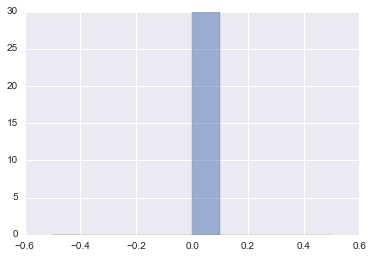

In [18]:
compare_rank(video_score, results.params, False, True)
# compare_rank(video_score, res, False, True)

In [40]:
model = Pairwise(np.array(pairs_truth), video_num, video_score)

sparsity_Nihar, sparsity_Isabelle = model.test_data_generation_sparsity(Nihar=True, Isabelle=True)

Current evaluating with 435 test pairs
Current evaluating with 391 test pairs
Current evaluating with 348 test pairs
Current evaluating with 304 test pairs
Current evaluating with 261 test pairs
Current evaluating with 217 test pairs
Current evaluating with 174 test pairs
Current evaluating with 130 test pairs
Current evaluating with 87 test pairs
Current evaluating with 43 test pairs


In [18]:
model = Pairwise(np.array(pairs_truth), video_num, video_score)

noise_Nihar, noise_Isabelle = model.test_data_generation_noise(Nihar=True, Isabelle=True)

Current evaluating with 0.000000 to flip
Current evaluating with 0.050000 to flip
Current evaluating with 0.100000 to flip
Current evaluating with 0.150000 to flip
Current evaluating with 0.200000 to flip
Current evaluating with 0.250000 to flip
Current evaluating with 0.300000 to flip
Current evaluating with 0.400000 to flip
Current evaluating with 0.500000 to flip


In [57]:
sparsity_Nihar

[7.22789995200075,
 9.078015813741567,
 10.406622786639671,
 12.189643260144701,
 12.098259837683624,
 12.696839038991838,
 13.007619191684302,
 13.359336385918152,
 13.422580021181439,
 13.877689422861881]

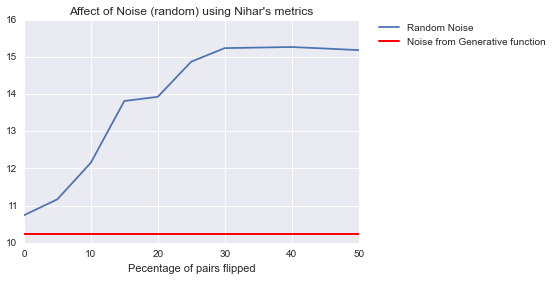

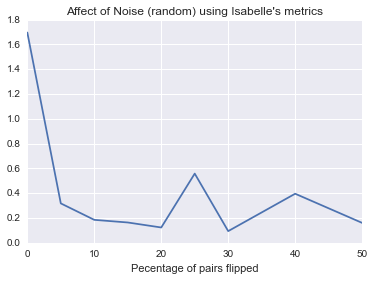

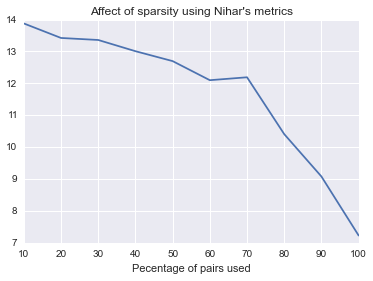

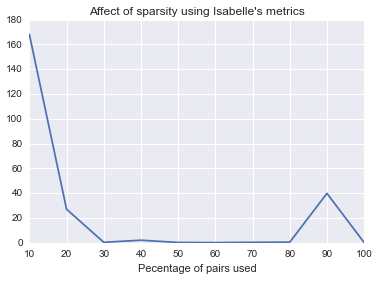

In [56]:
plt.figure()
plt.plot(np.array((0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5))*100,noise_Nihar,label='Random Noise')
plt.title('Affect of Noise (random) using Nihar\'s metrics')
plt.xlabel('Pecentage of pairs flipped')
plt.axhline(y=10.2244847722,linewidth=2, color='r',label='Noise from Generative function')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.figure()
plt.plot(np.array((0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5))*100,noise_Isabelle)
plt.title('Affect of Noise (random) using Isabelle\'s metrics')
plt.xlabel('Pecentage of pairs flipped')


plt.figure()
cs3 = plt.plot(np.array((1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1))*100,sparsity_Nihar)
plt.title('Affect of sparsity using Nihar\'s metrics')
plt.xlabel('Pecentage of pairs used')



plt.figure()
plt.plot(np.array((1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1))*100,sparsity_Isabelle)
plt.title('Affect of sparsity using Isabelle\'s metrics')
plt.xlabel('Pecentage of pairs used')

In [184]:
model = Pairwise(np.array(pairs_truth), video_num, video_score)
w_init = np.ones(video_num)
model.fit(w_init)

In [ ]:
print 'Nihars method error using generative model', model.test_data_generation_noise_generative_model(Nihar=True)

In [ ]:
print 'Nihars method error using generative model', model.test_data_generation_noise_generative_model(Nihar=True)

# Stability Test
Stability test are consists of two methods: 
* Witholding a subset of pairs, and see if the results agree with these pairs
* Reverse construct pairs from predicted values

In [62]:
def stability_withold(pairs_truth, truth, total_pairs, video_score):
    """
    pairs: the original pairs in the pairwise comparison
    truth: ground truth video score
    predicted: predicted video score
    total_pairs: total number of pairs in the pairwise comparison
    
    This function will output an error rate of witholding 10% of the data
    """
    sample_space = [int(i) for i in np.linspace(1,total_pairs-1,total_pairs-1).tolist()]
    
    samples = random.sample(range(total_pairs), int(total_pairs*0.9)-1)
    test_samples = [x for x in sample_space if x not in samples]
        
    sample_pairs = [pairs_truth[i] for i in samples]
    test_pairs = [pairs_truth[i] for i in test_samples]
    
    model = Pairwise(np.array(sample_pairs), total_pairs , truth)

    w_init = np.ones(len(truth))

    start_time = time.time()
    results = model.fit(w_init)
    predicted = model.rank[0]
    
    error_pct = 0
    for pair in test_pairs:
        if predicted[pair[0]] < predicted[pair[1]]:
            error_pct += 1
            print pair, predicted[pair[0]] , predicted[pair[1]],  video_score[pair[0]] , video_score[pair[1]]
    error_pct /= len(test_pairs)
            
    print  'Time Spent: %.2f seconds' %float(time.time() - start_time)
    print error_pct

In [63]:
# def stability_reverse():
    

In [64]:
stability_withold(pairs_truth, video_score, total_pairs,video_score)

(4, 28) 12.9999800002 15.9999700003 2.7 2.6
(9, 20) -5.9999800002 3.9999300007 -1.5 -1.9
(29, 26) 18.0000399996 23.9999800002 4.5 3.3
Time Spent: 43.65 seconds
0.0666666666667


In [71]:
def compare_rank_2(video_score, result1, result2, verbose=False, hist=False, pct=100):
    true_order = np.array(video_score).argsort()
    true_ranks = true_order.argsort()

    temp_o = np.array(result1).argsort()
    temp_r = temp_o.argsort()
    
    temp_o2 = np.array(result2).argsort()
    temp_r2 = temp_o.argsort()

    resolution = 0.1
    video_score1 = np.round(np.array(result1)/resolution)*resolution
    video_score2 = np.round(np.array(result2)/resolution)*resolution
    
    if verbose:
        print 'Result1 Order \t Result2 Order \t True Order \t Result Score1 \t Result Score2 \t Ture Score'
        for i in range(len(temp_r)):
            print temp_r2[i],'\t\t',temp_r[i], '\t\t', true_ranks[i], '\t\t', video_score1[i], '\t\t', video_score2[i], '\t\t', video_score[i]
            
    if hist:
        diff = np.abs(temp_r - true_ranks)
        plt.hist(diff, alpha=0.5)

In [59]:
video_num = 30

video_score = np.random.uniform(-5,5,video_num)
resolution = 0.1
video_score = np.round(video_score/resolution)*resolution

pairs_truth = []

for i in range(len(video_score)-1):
    for j in range(i+1, len(video_score)):
        if video_score[i] > video_score[j]:
            pairs_truth.append((i,j))
        else:
            pairs_truth.append((j,i))
            
total_pairs = len(pairs_truth)

In [73]:
f = 0.5

sample_space = [int(i) for i in np.linspace(1,total_pairs-1,total_pairs-1).tolist()]

test_idx = random.sample(range(total_pairs), int(total_pairs*f)-1)
validation_idx = [x for x in sample_space if x not in test]

test = [pairs_truth[i] for i in test_idx]
validation = [pairs_truth[i] for i in validation_idx]

model1 = Pairwise(np.array(test), video_num, video_score)
model2 = Pairwise(np.array(validation), video_num, video_score)

w_init = np.ones(video_num)

start_time = time.time()
result1 = model1.fit(w_init)
result2 = model2.fit(w_init)
print  'Time Spent: %.2f seconds' %float(time.time() - start_time)


Time Spent: 83.73 seconds


In [74]:
compare_rank_2(video_score, model1.rank[0], model2.rank[0], True)

Result1 Order 	 Result2 Order 	 True Order 	 Result Score1 	 Result Score2 	 Ture Score
9 		9 		9 		-3.0 		-10.0 		-2.3
23 		23 		25 		3.0 		21.0 		2.9
11 		11 		14 		-3.0 		-1.0 		0.6
22 		22 		21 		2.0 		13.0 		2.3
6 		6 		7 		-3.0 		-15.0 		-2.5
1 		1 		2 		-11.0 		-26.0 		-3.7
14 		14 		18 		-2.0 		7.0 		1.8
18 		18 		12 		1.0 		-5.0 		0.5
7 		7 		8 		-3.0 		-13.0 		-2.4
2 		2 		11 		-6.0 		-7.0 		-0.7
27 		27 		27 		11.0 		26.0 		3.1
21 		21 		20 		2.0 		11.0 		2.2
0 		0 		0 		-11.0 		-23.0 		-4.8
13 		13 		13 		-2.0 		-3.0 		0.5
3 		3 		17 		-6.0 		5.0 		1.7
19 		19 		4 		2.0 		-24.0 		-3.0
16 		16 		10 		-1.0 		-9.0 		-1.6
4 		4 		1 		-5.0 		-28.0 		-4.6
12 		12 		5 		-2.0 		-20.0 		-2.9
15 		15 		22 		-2.0 		15.0 		2.5
17 		17 		23 		1.0 		18.0 		2.7
8 		8 		6 		-3.0 		-18.0 		-2.7
28 		28 		28 		11.0 		28.0 		4.4
20 		20 		3 		2.0 		-22.0 		-3.0
29 		29 		29 		16.0 		23.0 		4.9
24 		24 		19 		4.0 		9.0 		1.9
25 		25 		24 		4.0 		20.0 		2.7
5 		5 		16 		-4.0 		3.0 		1.6
26 		26